# REDES BAYESIANAS 
PRESENTADO POR: 

Alanis Nicole Forero Salas
Kevin Jaimes Carrillo
Juan Buitrago

# EN QUE CONSISTE ESTE PROYECTO:
    Implemntacion de un motor de inferencia por Enumeracion

# COMO SE DESEA LOGRAR:
    1. Implementamos una Red Bayesiana
       - Grafo aciclico
       - Regla de la cadena, los padres son los condicionantes de una variable dada
    2. Inferencia Bayesiana por Enumeracion
       - Implementacion de los pasos

# QUE SE LOGRO:
   1. Leer archivos cvs
   2. Creacion y presentacion del grafo aciclico en cuestion
   3. Practica con ejemplo basico

    
# REFERENCIAS:
https://youtu.be/xDUDX6B1ltk?si=pVjcNBb5QC5GSLdI
https://www.ellaberintodefalken.com/2020/02/grafos-con-networkx.html
https://personales.unican.es/gutierjm/cursos/expertos/Reglas.pdf
https://idus.us.es/bitstream/handle/11441/77565/Ortiz%20Padilla%20%C3%8D%C3%B1igo%20TFG.pdf?sequence=1&isAllowed=y


# MODELAR UNA RED BAYESIANA

En primera instancia se trabajara con el ejemplo del tren en mantenimiento

In [1]:
import pandas as pd
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
import matplotlib.pyplot as plt
import networkx as nx
import os
import itertools
import numpy as np

c:\Users\Alanis\OneDrive\Documentos\Universidad Javeriana\Sexto semestre\Introduccion IA\Proyecto 3\proyecto3IA\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


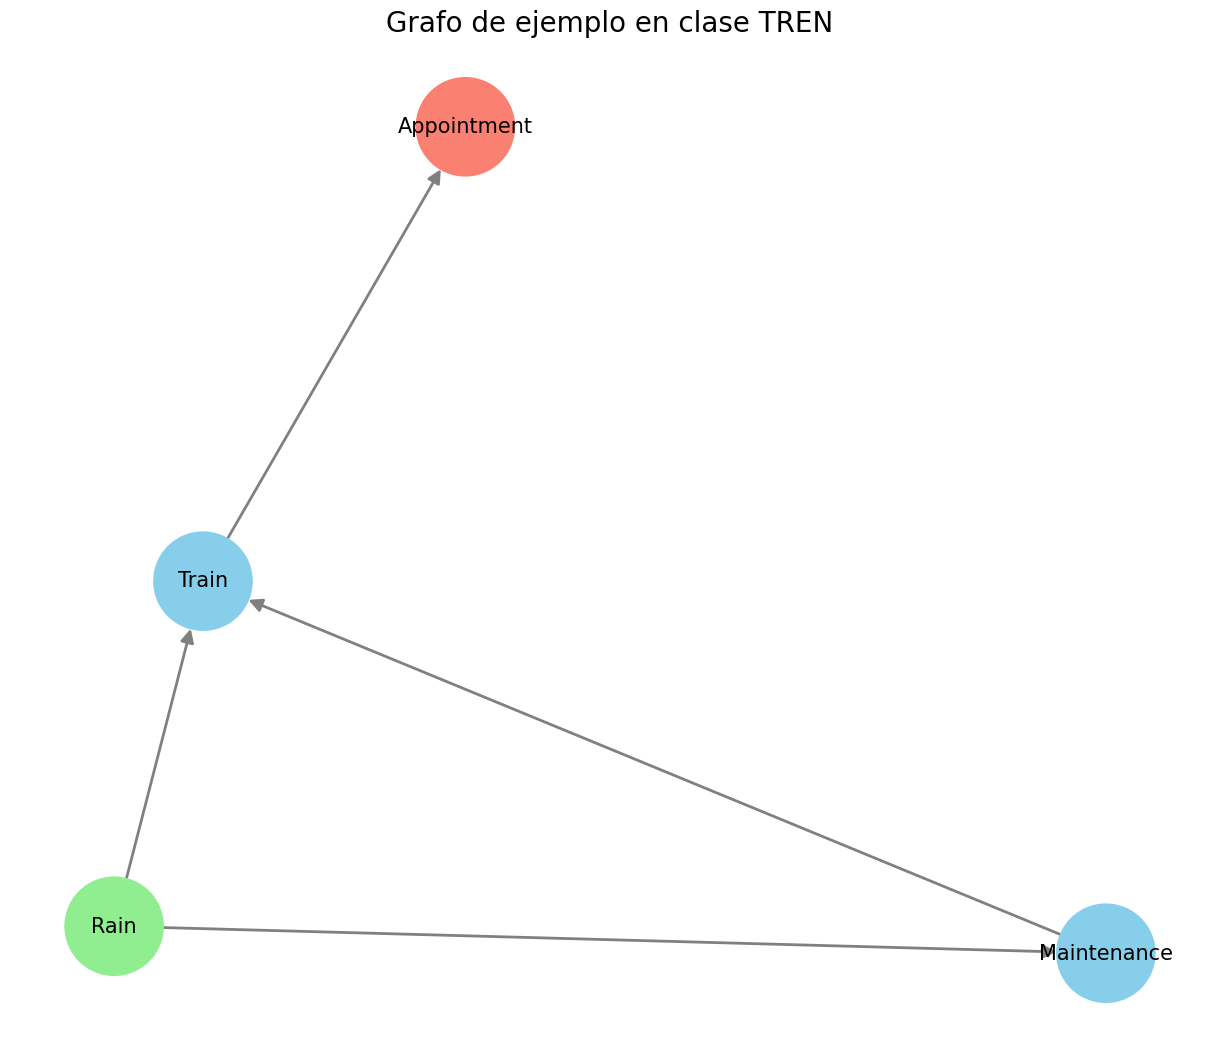

In [2]:
def crear_grafo(archivo):
    df = pd.read_csv(archivo)
    G = nx.DiGraph()

    # Crear el grafo y agregar las aristas
    for index, row in df.iterrows():
        G.add_edge(row['Padre'], row['Hijo'])#asi le puse a mis columnas en el archivo de relaciones

    # Asignar colores por nodo de acuerdo a su grado (La verdad solo que se vea mas lindo)
    color_map = []
    for node in G:
        if G.in_degree(node) == 0:  # Nodo sin dependencias
            color_map.append('lightgreen')
        elif G.out_degree(node) == 0:  # Nodo sin descendientes
            color_map.append('salmon')
        else:  # Nodos intermedios
            color_map.append('skyblue')

    # Dibujar el grafo
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G, seed=42)  
    nx.draw(G, pos, node_color=color_map, with_labels=True, edge_color='gray', width=2, node_size=5000, font_size=15, font_color='black', arrows=True, arrowsize=20)

    # que se vea mejor :)
    plt.title('Grafo de ejemplo en clase TREN', size=20)#TOCA CAMBIARLE EL NOMBRE EN CADA
    plt.show()

crear_grafo('relaciones.csv')

# MOTOR DE INFERENCIA POR ENUMERACION

# INFERENCIA BAYESIANA

In [3]:
cpt_rain = pd.read_csv('cpt_rain.csv')
cpt_appointment = pd.read_csv('cpt_appointment.csv')
cpt_train = pd.read_csv('cpt_train.csv')
cpt_maintenance = pd.read_csv('cpt_maintenance.csv')
#mejor vuelvo a leer relaciones uno nunca sabe
relaciones = pd.read_csv('relaciones.csv')

In [4]:
print(cpt_rain)

    Rain  Probability
0   none          0.7
1  light          0.2
2  heavy          0.1


In [5]:
print(cpt_appointment)

     Train Appointment  attend  miss
0  on time      attend     0.9   0.1
1  delayed      attend     0.6   0.4


In [6]:
print(cpt_train)

    Rain Maintenance    Train  on time  delayed
0   none         yes  on time      0.8      0.2
1   none          no  on time      0.9      0.1
2  light         yes  on time      0.6      0.4
3  light          no  on time      0.7      0.3
4  heavy         yes  on time      0.4      0.6
5  heavy          no  on time      0.5      0.5


In [7]:
print(cpt_maintenance)

    Rain Maintenance  yes   no
0   none         yes  0.4  0.6
1   none          no  0.6  0.4
2  light         yes  0.2  0.8
3  light          no  0.8  0.2
4  heavy         yes  0.1  0.9
5  heavy          no  0.9  0.1


In [17]:
def obtener_probabilidad_marginal(variable, valor):
    tablas_marginales = {
        'Rain': cpt_rain, 
        'Appointment': cpt_appointment, 
        'Maintenance': cpt_maintenance,  
        'Train': cpt_train  
    }
    
    tabla_marginal = tablas_marginales[variable]
    probabilidad = tabla_marginal.loc[tabla_marginal[variable] == valor, 'Probability'].values[0]
    return probabilidad

# Ejemplo para imprimir la probabilidad marginal de que no llueva
resultado = obtener_probabilidad_marginal('Rain', 'none')
print("La probabilidad de que no llueva es:", resultado)

La probabilidad de que no llueva es: 0.7


In [18]:
def obtener_probabilidad_condicional(variable, valor, condiciones):
    tablas_cpt = {
        'Rain': cpt_rain,
        'Appointment': cpt_appointment, 
        'Maintenance': cpt_maintenance,  
        'Train': cpt_train  
    }
    
    tabla_cpt = tablas_cpt[variable]
    filtro = (tabla_cpt[list(condiciones.keys())] == pd.Series(condiciones)).all(axis=1)
    probabilidad = tabla_cpt.loc[filtro, valor].values[0]
    return probabilidad

condiciones = {'Rain': 'none', 'Maintenance': 'yes'}
resultado = obtener_probabilidad_condicional('Train', 'on time', condiciones)
print("La probabilidad de que el tren esté a tiempo dado que no llueve y hay mantenimiento es:", resultado)

La probabilidad de que el tren esté a tiempo dado que no llueve y hay mantenimiento es: 0.8


# Haciendo traza

In [21]:
def calcular_probabilidad_conjunta(eventos):
    dependencias = dict(zip(relaciones['Hijo'], relaciones['Padre']))
    
    probabilidad_conjunta = 1
    print("Iniciando cálculo de probabilidad conjunta")
    for variable, valor in eventos.items():
        if variable in dependencias:
            padre = dependencias[variable]
            condiciones = {padre: eventos[padre]}
            prob = obtener_probabilidad_condicional(variable, valor, condiciones)
            print(f"Calculando P({variable}={valor} | {condiciones}): {prob}")
        else:
            prob = obtener_probabilidad_marginal(variable, valor)
            print(f"Calculando P({variable}={valor}): {prob}")

        probabilidad_conjunta *= prob
        print(f"Probabilidad conjunta actualizada: {probabilidad_conjunta}")
    
    return probabilidad_conjunta

# Definir los eventos
eventos = {
    'Rain': 'none',
    'Maintenance': 'no',
    'Train': 'on time',
    'Appointment': 'attend'
}

# Calcular la probabilidad conjunta para estos eventos
resultado_conjunto = calcular_probabilidad_conjunta(eventos)

# Imprimir el resultado
print("La probabilidad conjunta de los eventos es:", resultado_conjunto)

Iniciando cálculo de probabilidad conjunta
Calculando P(Rain=none): 0.7
Probabilidad conjunta actualizada: 0.7
Calculando P(Maintenance=no | {'Rain': 'none'}): 0.6
Probabilidad conjunta actualizada: 0.42
Calculando P(Train=on time | {'Maintenance': 'no'}): 0.9
Probabilidad conjunta actualizada: 0.378
Calculando P(Appointment=attend | {'Train': 'on time'}): 0.9
Probabilidad conjunta actualizada: 0.3402
La probabilidad conjunta de los eventos es: 0.3402


In [16]:
# Probabilidad de que el tren esté a tiempo o retrasado
prob_tren_on_time = obtener_probabilidad_condicional('Train', 'on time', {'Rain': 'light', 'Maintenance': 'no'})
prob_tren_delayed = obtener_probabilidad_condicional('Train', 'delayed', {'Rain': 'light', 'Maintenance': 'no'})

# Imprimir las probabilidades del tren
print("Probabilidad de que el tren esté a tiempo:", prob_tren_on_time)
print("Probabilidad de que el tren esté retrasado:", prob_tren_delayed)

# Probabilidad de asistir a la reunión dado que el tren está a tiempo
prob_asistir_on_time = obtener_probabilidad_condicional('Appointment', 'attend', {'Train': 'on time'})
# Probabilidad de asistir a la reunión dado que el tren está retrasado
prob_asistir_delayed = obtener_probabilidad_condicional('Appointment', 'attend', {'Train': 'delayed'})

# Imprimir las probabilidades de asistir a la reunión
print("Probabilidad de asistir a la reunión si el tren está a tiempo:", prob_asistir_on_time)
print("Probabilidad de asistir a la reunión si el tren está retrasado:", prob_asistir_delayed)

# Calcular la probabilidad total de asistir a la reunión
prob_total_asistir = (prob_tren_on_time * prob_asistir_on_time) + (prob_tren_delayed * prob_asistir_delayed)

# Imprimir la probabilidad total de asistir a la reunión
print("Probabilidad total de asistir a la reunión:", prob_total_asistir)

prob_total_no_asistir = 1 - prob_total_asistir 

print("Probabilidad total de no asistir a la reunion: ", prob_total_no_asistir)

Tabla CPT para Train:
    Rain Maintenance    Train  on time  delayed
0   none         yes  on time      0.8      0.2
1   none          no  on time      0.9      0.1
2  light         yes  on time      0.6      0.4
3  light          no  on time      0.7      0.3
4  heavy         yes  on time      0.4      0.6
5  heavy          no  on time      0.5      0.5
Condiciones aplicadas: {'Rain': 'light', 'Maintenance': 'no'}
Filtrando tabla para condiciones, buscando 'on time':
    Rain Maintenance    Train  on time  delayed
3  light          no  on time      0.7      0.3
Probabilidad de Train = on time dado {'Rain': 'light', 'Maintenance': 'no'}: 0.7
Tabla CPT para Train:
    Rain Maintenance    Train  on time  delayed
0   none         yes  on time      0.8      0.2
1   none          no  on time      0.9      0.1
2  light         yes  on time      0.6      0.4
3  light          no  on time      0.7      0.3
4  heavy         yes  on time      0.4      0.6
5  heavy          no  on time      0.5 

# Ejercicio nuevo